# Lab session 3: Global Optimization with Gaussian Processes

Course in Bayesian optimization, 29th October 2015
Written by Javier Gonzalez and Zhenwen Dai.

The goal of this lab session is: (1) to use Bayesian optimization to tune the parameters of Machine Learning algorithms and (2) to use parallel BO methods that will help us to save computational time when tuning our algorithms.

As in previous sessions, the technical material associated to the methods used in this lab can be found in the slides of the tutorial. 

# 1 Tuning the Parameters of Machine Learning algorithms

After learning some theory about Bayesian Optimization, let's have a look at how to use GPyOpt to tune the hyper-parameters of a practical algorithm. Here shows how to tune the hyper-parameters for Support Vector Regression (SVR) with the toy dataset that we have seen from Lab 1: the Olympic marathon dataset.

We split the original dataset into the training data (first 20 datapoints) and testing data (last 7 datapoints). The performance of SVR is evaluated in terms of Rooted Mean Squared Error (RMSE) on the testing data.

As in previous labs, we start loading the requires modules.

In [1]:
%pylab inline  
import GPy
import GPyOpt
import numpy as np
from numpy.random import seed
seed(12345)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Let's load the dataset
GPy.util.datasets.authorize_download = lambda x: True # prevents requesting authorization for download.
data = GPy.util.datasets.olympic_marathon_men()
X = data['X']
Y = data['Y']
X_train = X[:20]
Y_train = Y[:20,0]
X_test = X[20:]
Y_test = Y[20:,0]

Let's first see the results with the default kernel parameters.

In [3]:
from sklearn import svm
svr = svm.SVR()
svr.fit(X_train,Y_train)
Y_train_pred = svr.predict(X_train)
Y_test_pred = svr.predict(X_test)
print "The default parameters obtained: C="+str(svr.C)+", epilson="+str(svr.epsilon)+", gamma="+str(svr.gamma)

The default parameters obtained: C=1.0, epilson=0.1, gamma=0.0


We compute the RMSE on the testing data and plot the prediction. With the default parameters, SVR does not give an OK fit to the training data but completely miss out the testing data well.

RMSE = 0.56330740612


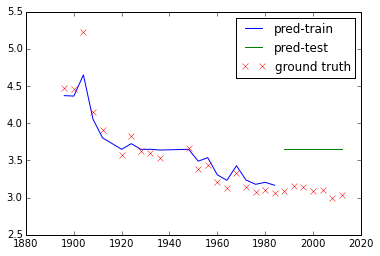

In [4]:
plot(X_train,Y_train_pred,'b',label='pred-train')
plot(X_test,Y_test_pred,'g',label='pred-test')
plot(X_train,Y_train,'rx',label='ground truth')
plot(X_test,Y_test,'rx')
legend(loc='best')
print "RMSE = "+str(np.sqrt(np.square(Y_test_pred-Y_test).mean()))

Now let's try **Bayesian Optimization**. We first write a wrap function for fitting with SVR. The objective is the RMSE from cross-validation. We optimize the parameters in *log* space.

In [5]:
nfold = 3
def fit_svr_val(x):
    x = np.atleast_2d(np.exp(x))
    fs = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        fs[i] = 0
        for n in range(nfold):
            idx = np.array(range(X_train.shape[0]))
            idx_valid = np.logical_and(idx>=X_train.shape[0]/nfold*n, idx<X_train.shape[0]/nfold*(n+1))
            idx_train = np.logical_not(idx_valid)
            svr = svm.SVR(C=x[i,0], epsilon=x[i,1],gamma=x[i,2])
            svr.fit(X_train[idx_train],Y_train[idx_train])
            fs[i] += np.sqrt(np.square(svr.predict(X_train[idx_valid])-Y_train[idx_valid]).mean())
        fs[i] *= 1./nfold
    return fs

We set the search interval of $C$ to be roughly $[0,1000]$ and the search interval of $\epsilon$ and $\gamma$ to be roughtly $[1\times 10^{-5},0.1]$.

In [6]:
bounds = [(0.,7.),(-12.,-2.),(-12.,-2.)]

We, then, create the GPyOpt object and run the optimization procedure. It might take a while.

In [7]:
opt = GPyOpt.methods.BayesianOptimization(f = fit_svr_val,            # function to optimize       
                                             bounds = bounds,         # box-constrains of the problem
                                             acquisition='LCB',       # LCB acquisition
                                             acquisition_par = 0.1)   # acquisition = Expected improvement

In [ ]:
# it may take a few seconds
opt.run_optimization(max_iter=50)
opt.plot_convergence()

Let's show the best parameters found. They differ significantly from the default parameters.

In [29]:
x_best = np.exp(opt.X[np.argmin(opt.Y)])
print "The best parameters obtained: C="+str(x_best[0])+", epilson="+str(x_best[1])+", gamma="+str(x_best[2])
svr = svm.SVR(C=x_best[0], epsilon=x_best[1],gamma=x_best[2])
svr.fit(X_train,Y_train)
Y_train_pred = svr.predict(X_train)
Y_test_pred = svr.predict(X_test)

The best parameters obtained: C=122.942566045, epilson=0.00718723477441, gamma=9.55746693679e-06


We can see SVR does a reasonable fit to the data. The result could be further improved by increasing the *max_iter*. 

RMSE = 0.0867753194072


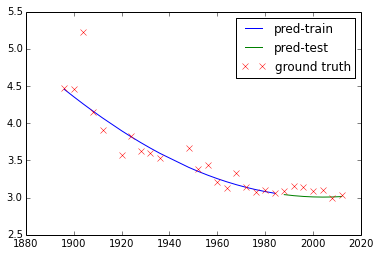

In [30]:
plot(X_train,Y_train_pred,'b',label='pred-train')
plot(X_test,Y_test_pred,'g',label='pred-test')
plot(X_train,Y_train,'rx',label='ground truth')
plot(X_test,Y_test,'rx')
legend(loc='best')
print "RMSE = "+str(np.sqrt(np.square(Y_test_pred-Y_test).mean()))

### Exercise 1

1.1 Why we do not directly use the RMSE of the whole training dataset as the objective? Why bother with cross-validation?

In [ ]:
## 1.1 Answer here 



2.1 Write a small comparative study to opimize the paramters of the SVR in the marathon data by changing the acquistion function and the model for the RMSE. Use the options that you learned yesterday. Comment on the results.

In [1]:
## 1.2 Answer here 



### Exercise 2

Select your favourite Machine Learning algorithm for [scikit-learn](http://scikit-learn.org/stable/), find and interesting data set (for instance form the [UCI  repository](http://archive.ics.uci.edu/ml/) and tune the parameters of your algorithm using GPyOpt. Use the code of this notebook as reference and be creative!

In [3]:
## 2 Answer here 




# Parallel Bayesian optimization

In this section we are going to learn how to use GPyOpt to run parallel BO methods. The goal of these approaches is to make use of all the computational power or our machine to perform the optimization. For instance, if we hace a computer with 4 cores, we may want to make 4 evaluations of $f$ in parallel everytime we test the performance of the algorithm.  

As in previous examples we use a synthetic objective function but you can think about doing the same with any function you like. In this case, we use the Branin function. For the optimization we will perturb the evaluations with Gaussian noise with sd = 0.1.

In [9]:
# --- Objective function
objective_true  = GPyOpt.fmodels.experiments2d.branin()                 # true function
objective_noisy = GPyOpt.fmodels.experiments2d.branin(sd = 0.1)         # noisy version
bounds = objective_noisy.bounds        

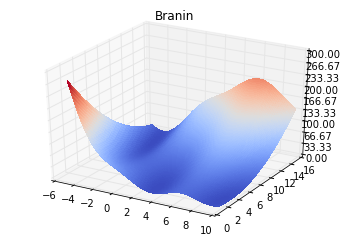

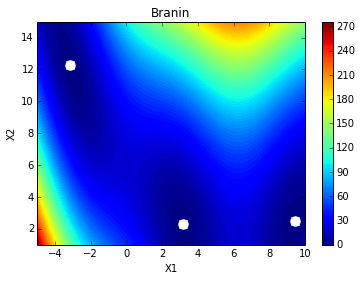

In [10]:
objective_true.plot()

As in previous cases, we create a GPyOpt object with the fucntion to optimize.

In [11]:
BO_demo_parallel = GPyOpt.methods.BayesianOptimization(f=objective_noisy.f,  # function to optimize       
                                            bounds = bounds,                     # box-constrains of the problem
                                            acquisition = 'EI',                 # Selects the Expected improvement
                                            acquisition_par = 0,                 # parameter of the acquisition function
                                            normalize = True)    

We will optimize this function by running 10 parallel evaluations in 3 cores of our machine. 

In [12]:
# --- Run the optimization
max_iter = 10                                                     

# --- Number of cores to use in the optimization (parallel evaluations of f)
n_cores = 3

No we run the optimization. We use the **Local penalization** method discussed in the lectures.

In [13]:
# --- Run the optimization (may take a few seconds)                         # evaluation budget
BO_demo_parallel.run_optimization(max_iter,                                 # Number of iterations
                                acqu_optimize_method = 'fast_random',       # method to optimize the acq. function
                                n_inbatch = n_cores,                        # size of the collected batches (= number of cores)
                                n_procs  = n_cores,                         # size of the collected batches (= number of cores)
                                batch_method='lp',                          # method to collected the batches (maximization-penalization) 
                                acqu_optimize_restarts = 1000,              # number of local optimizers
                                eps = 1e-6)    

*Optimization completed:
   -Maximum number of iterations reached.


1

We plot the resutls. Observe that the final number of evaluations that we will make is $10*4=40$. 

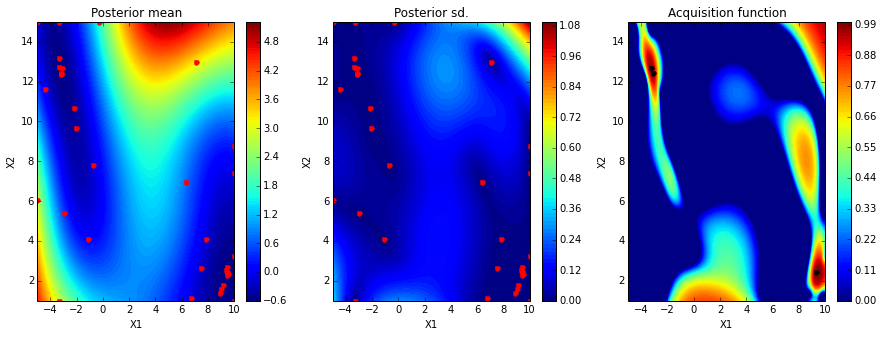

In [14]:
BO_demo_parallel.plot_acquisition()

See how the method explores the space using the four parallel evaluations of $f$ and it is able to identify the location of one of the minimum. 

### Exercise 3

3.1 Try and compare other parallelization mehods available in GPyOpt. The alternatives that you have are  'predictive' (to build the batches based on fake observations produced by the model) and 'random' (where the first location is computed by optimizing the acquisition and the rest by taking a random sample of the space). 

In [26]:
## 3.1 Anser here




3.2 Compare the results of one of the three parallelizations with the resutls that you would get by using a sequential policy. Compare the resutls in terms of the running time and in terms of the number of iterations.

### Exercise 4

4.1 Repeat Exercise 4 using a parallel approach. Now you should be able to make a more intensive exploration of the parameter space. 

In [ ]:
## 4.1 Anser here



